# Set up

In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\jana\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [19]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [20]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [21]:
imgs, labels = next(train_batches)

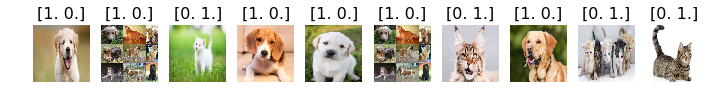

In [22]:
plots(imgs, titles=labels)

# Build and train CNN

In [23]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

In [24]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 8s - loss: 7.5538 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 7s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 7s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 8s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 7s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


# Predict

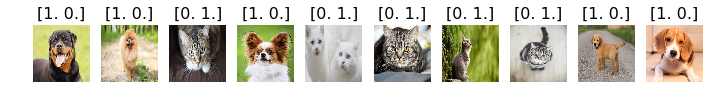

In [27]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [28]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1.], dtype=float32)

In [29]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [30]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [31]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 5]
 [0 5]]


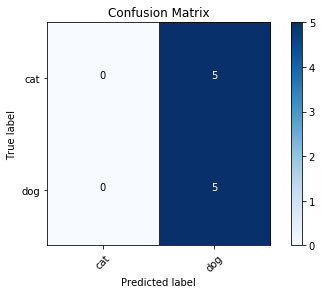

In [33]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Build Fine-tuned VGG16 model

In [34]:
#from keras.models import load_model
#vgg16_model = load_model('VGG16_cats_and_dogs.h5')

In [35]:
vgg16_model = keras.applications.vgg16.VGG16()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467904/553467096 [==============================] - 303s 1us/step


In [36]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [37]:
type(vgg16_model)

keras.engine.training.Model

In [38]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [40]:
model.layers.pop()

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [42]:
for layer in model.layers:
    layer.trainable = False

In [43]:
model.add(Dense(2, activation='softmax'))

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train the fine-tuned VGG16 model

In [45]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5


In [20]:
#old model results
#model.fit_generator(train_batches, steps_per_epoch=4, 
#                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
2s - loss: 7.6562 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
2s - loss: 7.6561 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
2s - loss: 8.4620 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
2s - loss: 9.2679 - acc: 0.4250 - val_loss: 10.0738 - val_acc: 0.3750


If saving this model with model.save('file.h5'), note that some users have reported the following error when loading the model using load_model('file.h5'):
    
ValueError: Dimension 0 in both shapes must be equal, but are 4096 and 1000.
Shapes are [4096,10] and [1000,10]. for 'Assign_61' (op: 'Assign') with input shapes: [4096,10], [1000,10].
   
If you receive this error, please see the answer in this stackoverflow post:
https://stackoverflow.com/questions/48482483/valueerror-when-loading-a-previously-saved-retrained-vgg16-model-using-keras

## Predict using fine-tuned VGG16 model

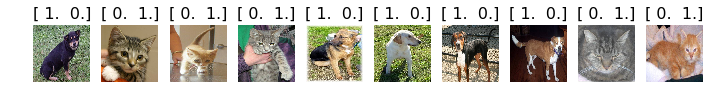

In [124]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [125]:
test_labels = test_labels[:,0]
test_labels

array([ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.], dtype=float32)

In [126]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [127]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[4 1]
 [1 4]]


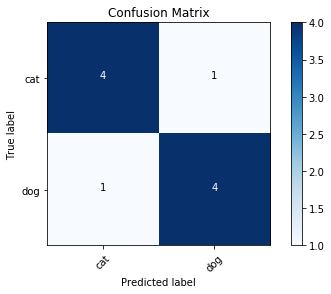

In [128]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[5 0]
 [5 0]]


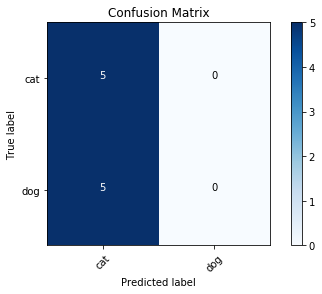

In [42]:
#old model results
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')